# Plan and Execute Agent

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OEPN_API_KEY")
_set_env("TAVILTY_API_KEY")

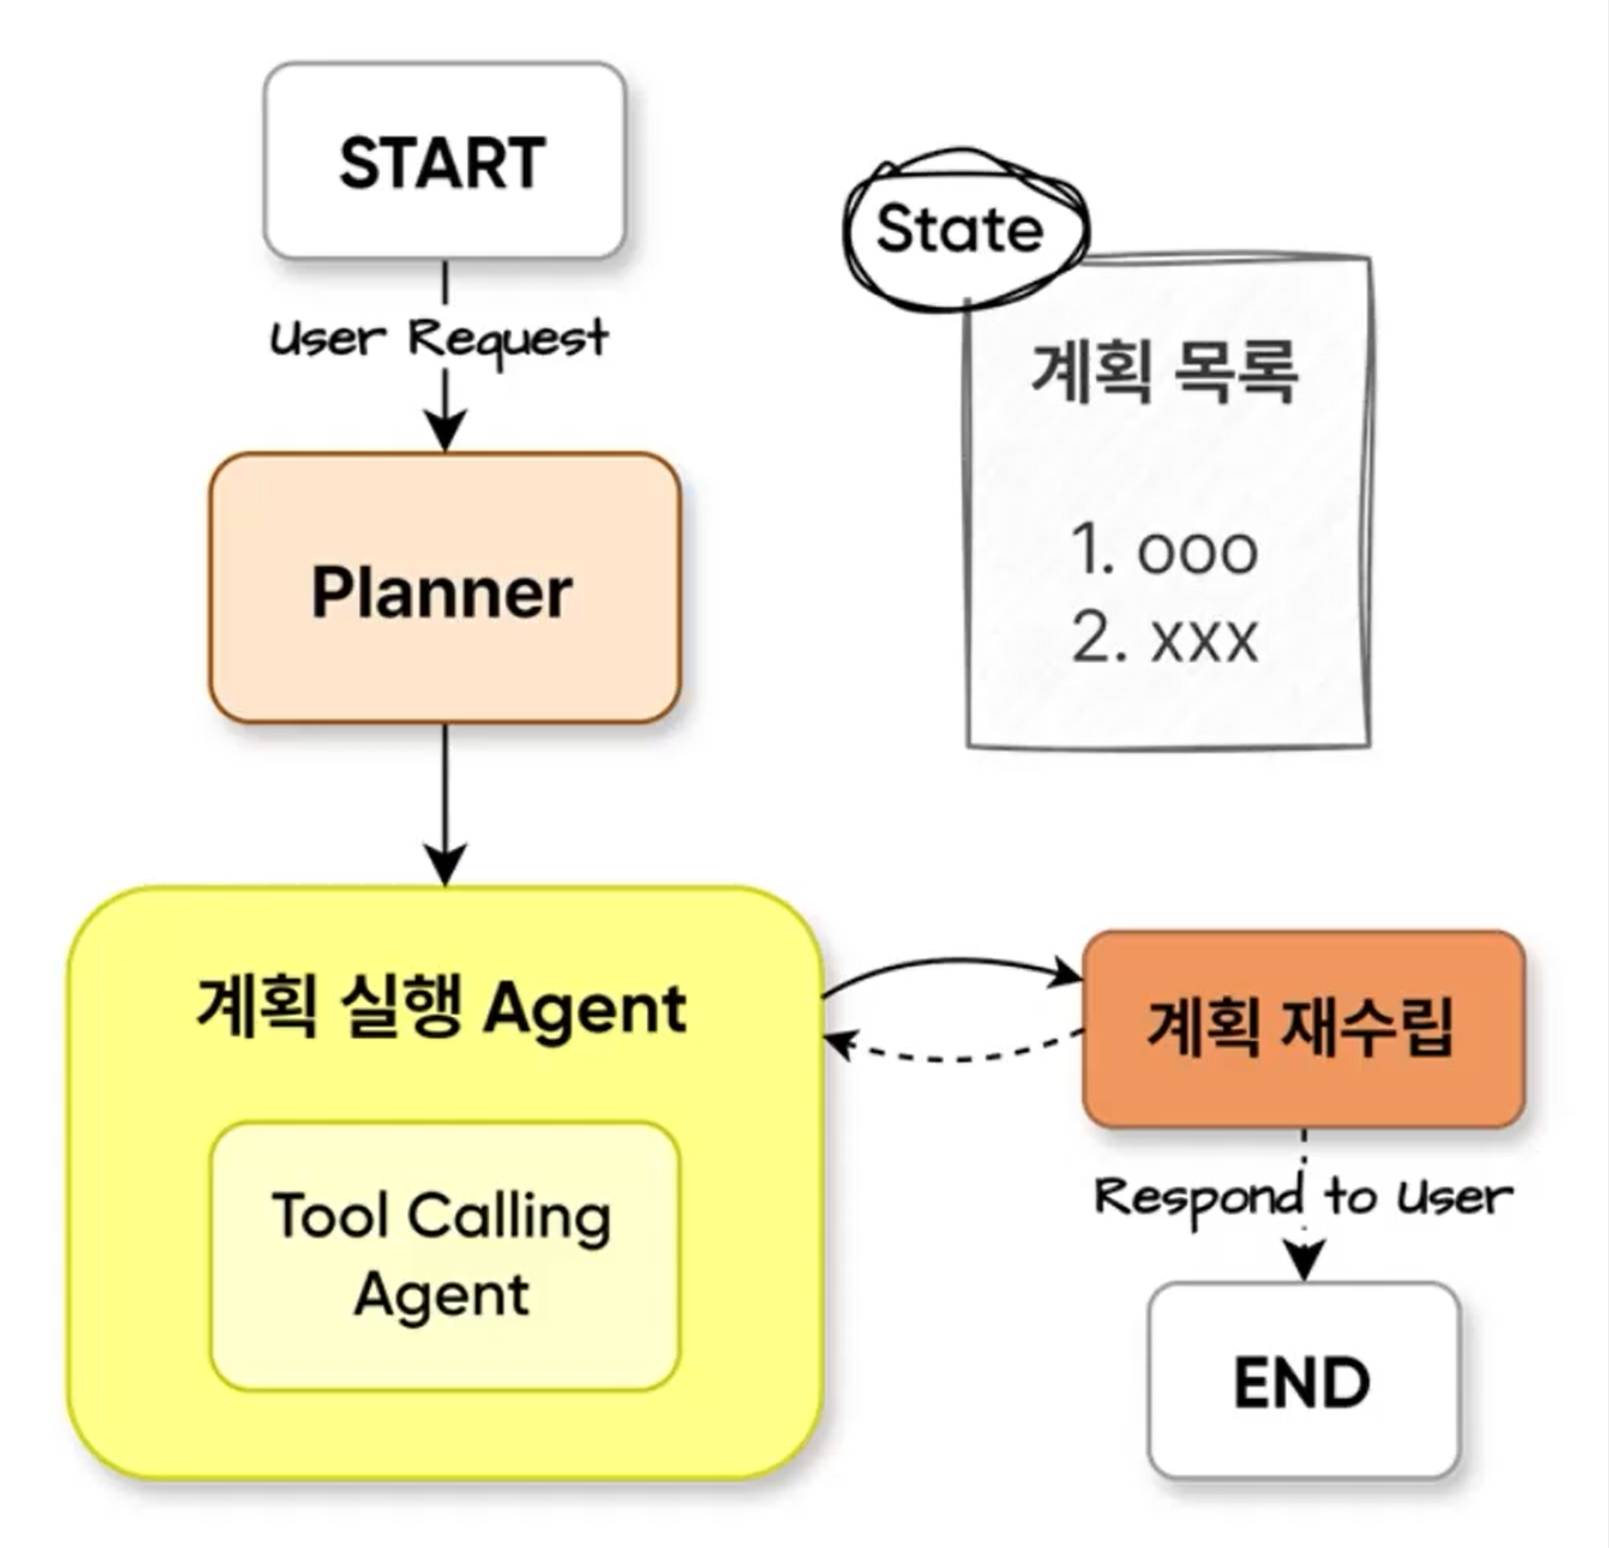

## Step 1. 웹 검색 Agent 만들기

- create_react_agent : pre-buildt ReAct agent

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=3)
tools = [search_tool]

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-40")
prompt = "You are a helpful assistant."
plan_executor = create_react_agent(llm, tools, prompt=prompt)

In [ ]:
# ReAct방식을 구현한 create_react_agent 함수를 사용하면
# 기존 도구 호출 필요시 도구를 호출하는 에이전트와 동일한 모양
from IPython.display import Image, display

display(Image(plan_executor.get_graph().draw_mermaid_png()))

In [ ]:
plan_executor.invoke({"messages": [("user", "2025년 한국의 최저시급은 얼마입니까?")]})

## Step 2. Planner 만들기

In [ ]:
from pydantic import BaseModel, Field
from typing import List

class Plan(BaseModel):
    """plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
            This plan should involve individual tasks, that if executed correctly will yield the correct answer.
            Do not add any superfluous steps. The result of the final step should be the final answer.
            Make sure that each step has all the information needed - do not skip steps."""
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

In [ ]:
plan_result = planner.invoke(
    {
        "messages": [HumanMessage(
            content="2025년 한국에서 개봉한 영화 중 가장 흥행한 영화는 무엇인가요?"
        )]
    }
)

In [ ]:
plan_result.step

## Step 3. RePlanner 만들기

In [ ]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer.
    Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has
    all the information needed - do not skip steps.
    
    Your objective was this:
    {input}
    
    Your original plan was this:
    {plan}
    
    You have currently done the follow steps:
    
    {past_steps}
    
    Update your plan accordingly.
    If no more steps are needed and you can return to the user, then respond with thtat.
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done.
    Do not return previously done steps as part of the plan."""
) # 더 이상 계획 진행이 필요없다면 답변하고, 아직 완료해야하는 단계가 있다면 해당 단계만 plan에 추가하기

In [ ]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str

class Act(BaseModel):
    """Action to perform."""

    # 더 이상의 step이 필요하지 않을 경우 Response 스키마로 응답. 
    # 더 이상의 step이 필요하면 Plan 스키마에 계획 재작성.
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answerm use Plan."
    )

In [ ]:
replanner = replanner_prompt | llm.with_structured_output(Act)

## Step 4. Graph 생성하기

In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps의: Annotated[List[Tuple], operator.add]
    response: str

In [ ]:
# 계획 생성
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

In [ ]:
# 계획 실행
def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))

    task = plan[0]
    task_formatted = f"""For the following plan:
    {plan_str}\n\nYou are tasked with executing step {1}, {task}"""

    agent_response = plan_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)]  # PlanExecute state의 past_steps의 튜플 형태에 맞추어 실행 완료한 계획과 결과를 저장
    }

In [ ]:
# 계획 수정
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response): # 답변이 바로 가능한 상태
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

In [ ]:
from langgraph.graph import END

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [ ]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(PlanExecute)

graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_step)
graph_builder.add_node("replan", replan_step)

graph_builder.add_edge(START, "planner")

graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replan")

graph_builder.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END]
)

graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "2024년 노벨문학상 수상자의 출신국가는 어디인가요?"}
for event in graph.stream(inputs, config=config, stream_mode="values"):
    for k, v in event.items():
        print(k, v)
    print("===============================")